In [798]:
import qutip as qt
import scqubits as scq
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

In [799]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.48,
                               cutoff = 110)

levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals))

A = 0.1
drive_op = n_op_energy_basis

omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+1.07838756e-17j 0.-5.20410568e-02j 0.-2.22638797e-01j
  0.-4.17687013e-01j 0.+4.24825374e-03j 0.-6.28748958e-02j]
 [0.+5.20410568e-02j 0.+9.84031091e-18j 0.+4.79485882e-01j
  0.-1.96197879e-01j 0.+7.39313106e-02j 0.+4.39799450e-02j]
 [0.+2.22638797e-01j 0.-4.79485882e-01j 0.-1.27968001e-18j
  0.+3.81301831e-01j 0.+4.30026592e-02j 0.-3.94097180e-02j]
 [0.+4.17687013e-01j 0.+1.96197879e-01j 0.-3.81301831e-01j
  0.-8.48860976e-19j 0.+4.75808155e-01j 0.+3.37475799e-01j]
 [0.-4.24825374e-03j 0.-7.39313106e-02j 0.-4.30026592e-02j
  0.-4.75808155e-01j 0.-8.66756086e-19j 0.-2.48046232e-01j]
 [0.+6.28748958e-02j 0.-4.39799450e-02j 0.+3.94097180e-02j
  0.-3.37475799e-01j 0.+2.48046232e-01j 0.-2.77347866e-17j]]

In [800]:
is_hermitian = drive_op.isherm
print("drive_op is Hermitian:", is_hermitian)

drive_op is Hermitian: True


In [801]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [802]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

In [803]:
times = np.linspace(0, 2000, 10000)

# options = qt.Options(nsteps=1000000, store_states=True, atol=1e-8, rtol=1e-6)
options = qt.Options(nsteps=1000000, store_states=True)


result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0010004043579101562
    run time: 1.5840697288513184
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 2000.0] (10000 steps)
  Number of e_ops: 6
  States saved.
>

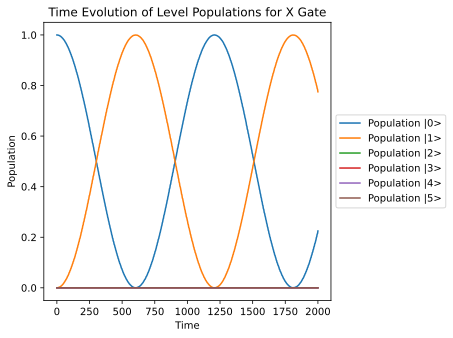

In [804]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Time Evolution of Level Populations for X Gate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Timing

In [805]:
d01 = abs(n_op_energy_basis[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

603.6757989431644

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

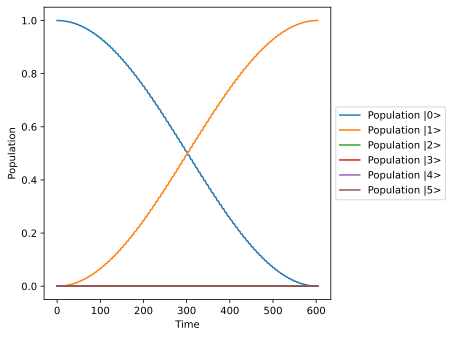

In [806]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Propagator

In [807]:
times = np.linspace(0, tx, 10000)


U = qt.propagator(H, times, args=args, options=options)

# U

In [808]:
U[-1]

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.10388938e-02+2.58298557e-04j  2.12029444e-01-9.77181428e-01j
  -3.55562119e-03-2.26581217e-03j  4.43758168e-03-2.53167590e-04j
  -4.21272008e-04-1.54519512e-04j -5.41422170e-04-7.66213202e-05j]
 [ 3.06916619e-01+9.51645067e-01j -1.09388536e-02+1.35107795e-03j
  -6.07819919e-03+3.39692674e-03j -1.79051572e-03+7.05875516e-04j
   2.60736978e-04-2.96053223e-04j -1.02215596e-04+7.81957000e-05j]
 [-6.25771678e-03+2.95529971e-03j  2.33099538e-03-3.58717319e-03j
   5.91680747e-01+8.05894016e-01j -7.08010816e-04-6.15756868e-03j
   7.88243833e-04-6.08662603e-04j -7.57613771e-04+2.85684390e-04j]
 [-1.93117381e-03+3.25929534e-04j -4.43758122e-03-1.47670801e-04j
   4.28114169e-03+4.45584972e-03j  2.47664237e-01+9.67778177e-01j
   1.54288005e-02-8.77479084e-03j  1.10338033e-02-1.64705805e-03j]
 [-3.94961655e-04+8.38813021e-05j -2.84895283e-04+3.19822531e-04j
  -6.96768466e-04+7.96665942e-04j -1.500

In [809]:
U[-1].full()[:2, :2]

array([[ 0.01103889+2.58298557e-04j,  0.21202944-9.77181428e-01j],
       [ 0.30691662+9.51645067e-01j, -0.01093885+1.35107795e-03j]])

In [810]:
U_final = qt.Qobj(U[-1].full()[:2, :2])

## Fidelity

In [811]:
X_ideal = qt.sigmax()

X_ideal

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [812]:
U = qt.propagator(H, tx, args=args, options=options)

U

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.10388939e-02+2.58298502e-04j  2.12029444e-01-9.77181428e-01j
  -3.55562451e-03-2.26581256e-03j  4.43756408e-03-2.53185827e-04j
  -4.21274837e-04-1.54520588e-04j -5.41414857e-04-7.65990721e-05j]
 [ 3.06916619e-01+9.51645066e-01j -1.09388536e-02+1.35107792e-03j
  -6.07819226e-03+3.39692808e-03j -1.79052499e-03+7.05867165e-04j
   2.60712331e-04-2.96064379e-04j -1.02224109e-04+7.81803276e-05j]
 [-6.25771344e-03+2.95530038e-03j  2.33098707e-03-3.58717433e-03j
   5.91680972e-01+8.05892495e-01j -7.07964539e-04-6.15749526e-03j
   7.88214164e-04-6.08684498e-04j -7.57601569e-04+2.85711469e-04j]
 [-1.93115241e-03+3.25949665e-04j -4.43757145e-03-1.47660304e-04j
   4.28107607e-03+4.45577179e-03j  2.47670253e-01+9.67771916e-01j
   1.54282189e-02-8.77512390e-03j  1.10336176e-02-1.64749213e-03j]
 [-3.94962341e-04+8.38839357e-05j -2.84865749e-04+3.19837982e-04j
  -6.96730912e-04+7.96679702e-04j -1.500

Calculating propagators...


Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 21247.43it/s]


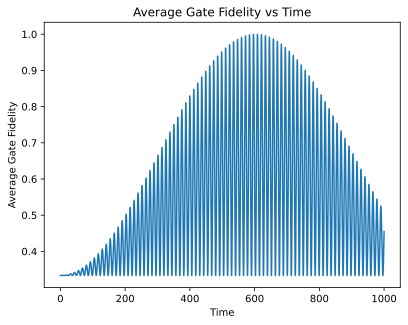

In [813]:
iterations = 10000
times = np.linspace(0, 1000, iterations)

print("Calculating propagators...")
U_list = qt.propagator(H, times, args=args, options=options)

fid_times = []
fid_values = []
for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    U_t = U_list[i]
    U_2lvl = qt.Qobj(U_t.full()[:2, :2])
    fid = qt.average_gate_fidelity(U_2lvl, X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [814]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

tx = peak_time

Peak average gate fidelity: 0.9997029251779391
Time at peak fidelity: 608.7608760876087


## Noise

In [815]:
gamma_ij = {}
for j in range(1, levels):
    for i in range(j):
        t1 = fluxonium.t1_capacitive(j, i, Q_cap=10e7)
        if t1 is not None and t1 > 0:
            rate = 1.0 / t1
            gamma_ij[(i, j)] = rate
            # gamma_ij[(j, i)] = rate  


In [816]:
gamma_ij

{(0, 1): 1.0105150256036662e-08,
 (0, 2): 1.2457805723540093e-07,
 (1, 2): 5.778185878582614e-07,
 (0, 3): 4.384719383144288e-07,
 (1, 3): 9.674498864173898e-08,
 (2, 3): 3.6546487378112276e-07,
 (0, 4): 4.535871654201096e-11,
 (1, 4): 1.373715093941894e-08,
 (2, 4): 4.647618634468422e-09,
 (3, 4): 5.689889229704482e-07,
 (0, 5): 9.935607252458311e-09,
 (1, 5): 4.861264190615338e-09,
 (2, 5): 3.903431069544427e-09,
 (3, 5): 2.8623658100727123e-07,
 (4, 5): 1.6702026913130087e-07}

In [817]:
c_ops = []
for (i, j), gamma in gamma_ij.items():
    # |i><j| operator
    cop = (np.sqrt(gamma)) * qt.basis(levels, i) * qt.basis(levels, j).dag()
    c_ops.append(cop)

In [818]:
c_ops

[Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=False
 Qobj data =
 [[0.         0.00010052 0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]],
 Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=False
 Qobj data =
 [[0.         0.         0.00035296 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.     

In [819]:
c_ops = [cop for (i, j), gamma in gamma_ij.items()
         for cop in [(np.sqrt(gamma)) * qt.basis(levels, i) * qt.basis(levels, j).dag()]]


Calculating propagators...


Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 17166.06it/s]


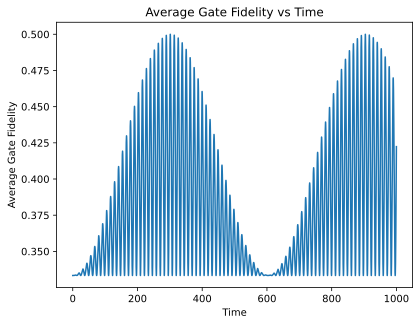

In [820]:
# times = np.linspace(0, 1000, iterations)

print("Calculating propagators...")
U_list = qt.propagator(H, times, c_ops=c_ops, args=args, options=options)

U_list

fid_times = []
fid_values = []

for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    U_t = U_list[i]
    U_2lvl = qt.Qobj(U_t.full()[:2, :2])
    fid = qt.average_gate_fidelity(U_2lvl, X_ideal)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [821]:
proj_op = qt.fock_dm(6,0) + qt.fock_dm(6, 1)

proj_op

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Calculating propagators...


Calculating fidelity: 100%|██████████| 10000/10000 [00:00<00:00, 11790.00it/s]


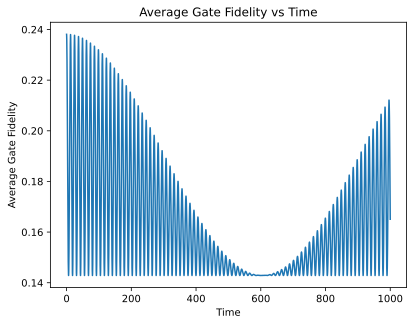

In [ ]:
#with the superoperators fix

times = np.linspace(0, 1000, iterations)

print("Calculating propagators...")
U_list = qt.propagator(H, times, c_ops=c_ops, args=args, options=options)

U_list

fid_times = []
fid_values = []

for i, t in enumerate(tqdm(times, desc='Calculating fidelity')):
    U_t = U_list[i]
    fid = qt.average_gate_fidelity(U_t, proj_op)
    
    fid_times.append(t)
    fid_values.append(fid)

plt.plot(np.array(fid_times), np.array(fid_values))
plt.xlabel('Time')
plt.ylabel('Average Gate Fidelity')
plt.title('Average Gate Fidelity vs Time')
plt.show()

In [823]:
peak_fidelity = np.max(fid_values)
print("Peak average gate fidelity:", peak_fidelity)

peak_index = np.argmax(fid_values)
peak_time = times[peak_index]
print("Time at peak fidelity:", peak_time)

Peak average gate fidelity: 0.23809523809523808
Time at peak fidelity: 0.0


## Optimal Control

Notes

H0 and drive consistent

Use optimal control and start with H0, keep the native operator but the Acos(wdt) portion is manipulable by methods like grape

- ideal gate = sigma x 

- find ft so that the drive operator creates a propagator that evolves to something close to sigmax or other defined gate